In [0]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Finals") \
    .getOrCreate()

file_path = "dbfs:/FileStore/tables/*.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True, timestampFormat="yyyy-MM-dd HH:mm:ss")

df.show()

+-----------------------------+------+----------------+--------+-------------+-------+--------+----+-----------------+--------------------+-------------+----------+-------------+------------------+----------------+---------------------------------+
|Transaction_unique_identifier| price|Date_of_Transfer|postcode|Property_Type|Old/New|Duration|PAON|             SAON|              Street|     Locality| Town/City|     District|            County|PPDCategory_Type|Record_Status - monthly_file_only|
+-----------------------------+------+----------------+--------+-------------+-------+--------+----+-----------------+--------------------+-------------+----------+-------------+------------------+----------------+---------------------------------+
|         {2B15DEFA-A09B-40...|162000|2007-08-24 00:00| N16 7BH|            F|      N|       L|183F|             null|        EVERING ROAD|       LONDON|    LONDON|      HACKNEY|    GREATER LONDON|               A|                                A|
|   

In [0]:
print(df.count())

3655310


In [0]:
import pyspark.sql.functions as F
# 1. Data Cleaning
# Dropping unwanted column
print(df.count())
df_cleaned = df.drop('postcode','PPDCategory_Type','PAON','SAON','Street','Locality','County','Record_Status - monthly_file_only')

df_cleaned = df_cleaned.withColumn('Location', F.concat_ws(",", df_cleaned["District"], df_cleaned["Town/City"]))
df_cleaned = df_cleaned.withColumn("Month", F.date_format("Date_of_Transfer", "yyyy-MM"))
df_cleaned = df_cleaned.drop("District")

uni_counts = df_cleaned.groupBy('Location').agg(F.count('*').alias('count'))
outliers = uni_counts.filter(F.col("count") < 5)
df_cleaned = df_cleaned.join(outliers, df_cleaned["Location"] == outliers["Location"], "left_anti")

df_cleaned.show()

3655310
+-----------------------------+-------+----------------+-------------+-------+--------+---------+--------------------+-------+
|Transaction_unique_identifier|  price|Date_of_Transfer|Property_Type|Old/New|Duration|Town/City|            Location|  Month|
+-----------------------------+-------+----------------+-------------+-------+--------+---------+--------------------+-------+
|         {7E466C7D-5F3C-4B...|1355000|2007-04-23 00:00|            S|      N|       F|   LONDON|RICHMOND UPON THA...|2007-04|
|         {B9363503-3A4B-4A...| 480000|2007-07-27 00:00|            T|      N|       F|   LONDON|RICHMOND UPON THA...|2007-07|
|         {E0D4EFD5-DF82-4F...| 549950|2007-03-30 00:00|            T|      N|       F|   LONDON|RICHMOND UPON THA...|2007-03|
|         {7E836103-4892-46...| 250000|2007-07-31 00:00|            F|      N|       L|   LONDON|RICHMOND UPON THA...|2007-07|
|         {072D64DB-2402-4F...| 341500|2007-11-22 00:00|            F|      N|       L|   LONDON|RICHMO

In [0]:
# 3.Feautre Enginering
def calculate_iqr_bounds(df, column_name):
    quantiles = df.approxQuantile(column_name, [0.25, 0.75], 0)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

# split dataset from london and nonlondon
london_df = df_cleaned.filter(F.col("Town/City") == "LONDON")
london_lower, london_upper = calculate_iqr_bounds(london_df, "price")

non_london_df = df_cleaned.filter(F.col("Town/City") != "LONDON")
non_london_lower, non_london_upper = calculate_iqr_bounds(non_london_df, "price")

# Dropping outliers using IQR
london_filtered = london_df.filter(
    (F.col("price") >= london_lower) &
    (F.col("price") <= london_upper))

non_london_filtered = non_london_df.filter(
    (F.col("price") >= non_london_lower) &
    (F.col("price") <= non_london_upper))

no_outliers_df_cleaned = london_filtered.union(non_london_filtered)

# Normalization of price
no_outliers_df_cleaned = no_outliers_df_cleaned.withColumn("Normalized_price", F.col("price") / 10000)

no_outliers_df_cleaned

Out[7]: DataFrame[Transaction_unique_identifier: string, price: int, Date_of_Transfer: string, Property_Type: string, Old/New: string, Duration: string, Town/City: string, Location: string, Month: string, Normalized_price: double]

In [0]:
display(london_df)

Transaction_unique_identifier price Date_of_Transfer Property_Type Old/New Duration Town/City Location Month {7E466C7D-5F3C-4B4A-A67A-C292C7C7C12E} 1355000 2007-04-23 00:00 S N F LONDON RICHMOND UPON THAMES,LONDON 2007-04 {B9363503-3A4B-4AF0-9519-C2955EDC8CE0} 480000 2007-07-27 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-07 {E0D4EFD5-DF82-4F26-8593-C299C86E6D0F} 549950 2007-03-30 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-03 {7E836103-4892-4620-8B88-C2A2538B3716} 250000 2007-07-31 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-07 {072D64DB-2402-4F24-A61F-B984DFF5FAEE} 341500 2007-11-22 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-11 {753162D8-A15E-4407-BAE1-BDC29A5A4178} 320000 2007-09-17 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-09 {C6E66B6B-FBF6-4BF1-8BCE-B6743D8BAD99} 710000 2007-07-13 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-07 {BAFA0850-5B05-48BA-A483-45075174A43E} 750000 2007-02-28 00:00 S N F LONDON RICHMOND UPON THAMES,LONDON 2007-02 {D71B8562-DE48-4E36-8401-3DE1788F3C67} 1150000 2007-08-23 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-08 {299E6205-17A6-4643-8EBC-3DEC9EBDA61D} 565000 2007-10-31 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-10 {7C37A56D-F244-4371-968F-B68141BEB1BB} 520000 2007-05-17 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-05 {B39455E0-8E2D-4410-AA79-3DF2026B40BE} 329950 2007-06-12 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-06 {47462E1C-812B-4C7D-97C7-C428925BDAA7} 375000 2007-05-08 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-05 {45479D9B-BD33-45CC-AF6D-BF462F69E764} 550000 2007-11-30 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-11 {B4FE405B-E25A-4F05-AE82-3A7A3DA75E33} 350000 2007-12-03 00:00 S N F LONDON RICHMOND UPON THAMES,LONDON 2007-12 {C162B9A9-0DF9-4141-A94D-BBB9CF97418E} 425000 2007-05-04 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-05 {05C09B8A-F172-4FBD-A41A-B9B9CD885C82} 447000 2007-06-20 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-06 {AE9A9E3F-FDDC-49E4-9B4A-C4460BB35D94} 350000 2007-08-22 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-08 {CF7EF853-2EA7-4B64-8C34-6DA89BC475E5} 270000 2007-05-04 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-05 {E5EF580C-ECD3-4F18-9845-B9BF952E283C} 880000 2007-05-04 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-05 {43B7D4EE-A914-4205-A271-BD4675221E0A} 600000 2007-07-26 00:00 S N F LONDON RICHMOND UPON THAMES,LONDON 2007-07 {5EA21498-5477-4340-A7EB-C0CE872B690C} 362500 2007-09-21 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-09 {F5B21407-24E4-4175-83D6-41AA9B1D52FF} 410000 2007-11-28 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-11 {D5E00B3D-E973-4628-9548-41ABBE75A02C} 2850000 2007-01-16 00:00 S N F LONDON RICHMOND UPON THAMES,LONDON 2007-01 {C30E886A-C228-4E71-8F41-3A8A9E8AE6DC} 695000 2007-08-14 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-08 {4945EF9D-2DD0-449C-9C80-6690456DF2F4} 2065000 2007-04-20 00:00 S N F LONDON RICHMOND UPON THAMES,LONDON 2007-04 {0D9A123E-3758-4C07-B954-32B08D8BC37C} 441000 2007-03-20 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-03 {F6BCA7CC-5ED2-4003-AA29-3649476A957E} 825000 2007-09-21 00:00 T N F LONDON RICHMOND UPON THAMES,LONDON 2007-09 {53F5FC65-8019-49EA-8688-48DAD92C52A1} 440000 2007-08-31 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-08 {77748120-D427-4D4B-BCCB-3A9C80F5542A} 920000 2007-08-24 00:00 S N F LONDON RICHMOND UPON THAMES,LONDON 2007-08 {817DE148-A56A-482B-B007-C7F2A87D1B56} 345000 2007-03-30 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-03 {1DB74DAD-6932-4D02-92B0-41C280B8E748} 470000 2007-10-05 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-10 {C359DC38-9F08-43E6-94F8-3E35D6F98581} 320000 2007-07-12 00:00 F N L LONDON RICHMOND UPON THAMES,LONDON 2007-07 {6F3E7DF4-1459-4FC4-8F89-6A3D3913F36A} 400000 2007-06-29 00:00 S N F LONDON RICHMOND UPON THAMES,LONDON 2007-06 {7F42F977-4AA3-46C8-9631-28124130B9F7} 360000 2007-08-28 00:00 F N L LONDON RIC

In [0]:
display(non_london_filtered)

Transaction_unique_identifier price Date_of_Transfer Property_Type Old/New Duration Town/City Location Month {251DDAB1-BBED-4E55-82AD-487EC7573371} 153000 2007-08-10 00:00 S N F LEEDS SELBY,LEEDS 2007-08 {1572FFA6-9A30-40C0-98CC-4163C22D44C7} 142500 2007-04-20 00:00 F Y L LEEDS SELBY,LEEDS 2007-04 {5D410F43-5AA2-40D1-BFEF-488662FDFFC5} 181995 2007-04-27 00:00 T Y F LEEDS SELBY,LEEDS 2007-04 {AD76E632-FDEA-482F-B0A8-B6A9DC7A6FBE} 215999 2007-10-29 00:00 D N F LEEDS SELBY,LEEDS 2007-10 {43523C9B-02F5-4D4B-9062-BF317C9095B1} 220000 2007-06-28 00:00 T N F LEEDS SELBY,LEEDS 2007-06 {5AF1795F-C862-4C98-A7DE-452469706FF7} 185950 2007-06-28 00:00 T Y F LEEDS SELBY,LEEDS 2007-06 {1AC0540A-A7D7-42C3-BE7F-BD5547D8669F} 273995 2007-12-20 00:00 D Y F LEEDS SELBY,LEEDS 2007-12 {D2A256AF-B3B0-41ED-A242-32CD371E29EC} 117500 2007-10-12 00:00 F N L LEEDS SELBY,LEEDS 2007-10 {DBA38220-52FD-42B3-95D0-4CAB1F57F01D} 264995 2007-03-30 00:00 D Y F LEEDS SELBY,LEEDS 2007-03 {66AB7D6E-4BA3-4E9A-9FEC-5AF863C8BF2E} 289995 2007-12-14 00:00 D Y F LEEDS SELBY,LEEDS 2007-12 {863B7643-2C10-4977-B001-3E60C0D0B236} 246000 2007-08-01 00:00 D N F LEEDS SELBY,LEEDS 2007-08 {60FB714D-8FF2-4150-9ACF-2F630FA649E6} 163000 2007-11-09 00:00 S N F LEEDS SELBY,LEEDS 2007-11 {A23DC90A-F0E6-4882-99E5-3E76DC03E61F} 176000 2007-07-06 00:00 S N F LEEDS SELBY,LEEDS 2007-07 {FBC0017E-088E-4D3B-BDF8-3E8D6A54221E} 206995 2007-06-22 00:00 T Y F LEEDS SELBY,LEEDS 2007-06 {46676054-FF5C-4372-AF25-6383DBEF8DD8} 206995 2007-04-29 00:00 T Y F LEEDS SELBY,LEEDS 2007-04 {3E68269E-446F-4735-96C4-2F9F364EC435} 249950 2007-05-30 00:00 T N F LEEDS SELBY,LEEDS 2007-05 {9A6BFEB0-B1C9-4904-8D37-638DAD54DBB6} 199995 2007-03-26 00:00 D N F LEEDS SELBY,LEEDS 2007-03 {026C9AAE-19B0-496F-975A-3338B002DB31} 187500 2007-03-23 00:00 T N F LEEDS SELBY,LEEDS 2007-03 {4B8AF230-6306-48B9-8819-28AAB9F5E602} 154000 2007-10-19 00:00 T N F LEEDS SELBY,LEEDS 2007-10 {563FBF45-5CA8-43D8-AB55-67496325AFC0} 165000 2007-06-29 00:00 S N F LEEDS SELBY,LEEDS 2007-06 {3EFFD16F-5A94-4D23-8F51-335F12DB7FC8} 172500 2007-08-14 00:00 S N F LEEDS SELBY,LEEDS 2007-08 {BFC1B944-C323-4765-8FB2-4983E3DE5C26} 75000 2007-01-18 00:00 F N L LEEDS SELBY,LEEDS 2007-01 {96CFB077-662E-452A-862D-49A108938FBC} 109995 2007-08-28 00:00 F N L LEEDS SELBY,LEEDS 2007-08 {AF6D0F64-C1E6-4DCE-8E70-EDE992C46269} 167500 2007-02-13 00:00 T N F LEEDS SELBY,LEEDS 2007-02 {5AB07342-5B13-4ABC-8495-58071D2A45C7} 245000 2007-11-05 00:00 T N F LEEDS SELBY,LEEDS 2007-11 {0021173F-7932-4AE5-A8BE-F66ECFF54160} 125000 2007-06-19 00:00 T N F LEEDS SELBY,LEEDS 2007-06 {959944E2-2B77-4F7D-8E17-58BB57541014} 191000 2007-06-08 00:00 S N F LEEDS SELBY,LEEDS 2007-06 {B79FDAEC-B9B9-43EB-B177-F523A1ABE115} 240000 2007-04-05 00:00 D N F LEEDS SELBY,LEEDS 2007-04 {EBAD43EA-F830-4EAB-AE94-FD875F875161} 124000 2007-07-13 00:00 S N F LEEDS SELBY,LEEDS 2007-07 {01196682-CAF6-4376-BBB7-51AB55E21191} 240000 2007-02-09 00:00 D N F LEEDS SELBY,LEEDS 2007-02 {907FF007-72BC-4480-BA79-51B8015DE5A4} 208995 2007-08-29 00:00 T Y F LEEDS SELBY,LEEDS 2007-08 {8B1033F3-05F5-49A0-8779-4BF761FAF878} 174950 2007-07-16 00:00 F Y L LEEDS SELBY,LEEDS 2007-07 {79919FBA-90FE-4BE9-9F94-4BFA11CEEA89} 155995 2007-03-16 00:00 F Y L LEEDS SELBY,LEEDS 2007-03 {A5E93780-FEDF-4614-823A-063C37DDCFC0} 182500 2007-07-27 00:00 T N F LEEDS SELBY,LEEDS 2007-07 {41A17327-0C67-4398-A889-54E3B08251A4} 173000 2007-02-23 00:00 T N F LEEDS SELBY,LEEDS 2007-02 {884695D0-7670-4B6D-8785-06473EBC9EEC} 165000 2007-10-15 00:00 S N F LEEDS SELBY,LEEDS 2007-10 {495700A2-0381-4FC7-B186-536D795A53CC} 180000 2007-05-04 00:00 D N F LEEDS SELBY,LEEDS 2007-05 {F6FA3B29-EEE7-4370-89FD-0D90975CA22D} 110000 2007-07-12 00:00 S N F LEEDS SELBY,LEEDS 2007-07 {A079201B-406A-4686-B5FA-02A63F84346D} 184995 2007-04-23 00:00 S Y F LEEDS SELBY,LEEDS 2007-04 {A6370F05-27BF-4226-A1A6-021B08D01176} 269995 2007-06-28 00:00 D Y F LEEDS SELBY,LEEDS 2007-06 {96AA088C-2465-47DB-B3B3-67CE182DC8DE} 183500 2007-06-14 00:00 D N F LEEDS SELBY,LEEDS 2007-

# Please continue to read the rest of code in ML_LR_all.pdf, ML_RF_all.pdf, ML_GBM_all.pdf  
# I modified them in different file and these are the final .py file i uploaded in GCP

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

indexers_ln = [
    StringIndexer(inputCol="Property_Type", outputCol="Property_Type_index"),
    StringIndexer(inputCol="Old/New", outputCol="Old/New_index"),
    StringIndexer(inputCol="Duration", outputCol="Duration_index")
]

encoders_ln = [
    OneHotEncoder(inputCols=["Property_Type_index"], outputCols=["Property_Type_vec"]),
    OneHotEncoder(inputCols=["Old/New_index"], outputCols=["Old/New_vec"]),
    OneHotEncoder(inputCols=["Duration_index"], outputCols=["Duration_vec"])
]

indexers_nln = [
    StringIndexer(inputCol="Property_Type", outputCol="Property_Type_index"),
    StringIndexer(inputCol="Old/New", outputCol="Old/New_index"),
    StringIndexer(inputCol="Duration", outputCol="Duration_index"),
    StringIndexer(inputCol="Town/City", outputCol="Town/City_index")
]

encoders_nln = [
    OneHotEncoder(inputCols=["Property_Type_index"], outputCols=["Property_Type_vec"]),
    OneHotEncoder(inputCols=["Old/New_index"], outputCols=["Old/New_vec"]),
    OneHotEncoder(inputCols=["Duration_index"], outputCols=["Duration_vec"]),
    OneHotEncoder(inputCols=["Town/City_index"], outputCols=["City_vec"])
]

# Combine indexers and encoders into a single pipeline
pipeline_ln = Pipeline(stages=indexers_ln + encoders_ln)
pipeline_nln = Pipeline(stages=indexers_nln + encoders_nln)

# Apply the pipeline to the DataFrame
new_london_df = pipeline_ln.fit(london_filtered).transform(london_filtered)
new_non_london_df = pipeline_nln.fit(non_london_filtered).transform(non_london_filtered)

new_non_london_df.count()

Out[17]: 1419671

In [0]:
from pyspark.ml.feature import VectorAssembler
df_V_ln = new_london_df
df_V = new_non_london_df

location_frequency = df_V.groupBy("Location").count()
location_frequency_ln = df_V_ln.groupBy("Location").count()
df_V = df_V.join(location_frequency, "Location")
df_V_ln = df_V_ln.join(location_frequency_ln, "Location")
df_V = df_V.withColumnRenamed("count", "location_frequency")
df_V_ln = df_V_ln.withColumnRenamed("count", "location_frequency")
df_V = df_V.withColumn("Year", F.year("Month")).withColumn("Month_Num", F.month("Month"))
df_V_ln = df_V_ln.withColumn("Year", F.year("Month")).withColumn("Month_Num", F.month("Month"))

df_V = df_V.drop("Transaction_unique_identifier","Location","Date_of_Transfer","Property_Type","Old/New","Duration","Month", "Property_Type_index", "Old/New_index","Duration_index", "Town/City", "Town/City_index")
df_V_ln = df_V_ln.drop("Transaction_unique_identifier","Location","Date_of_Transfer","Property_Type","Old/New","Duration","Month", "Property_Type_index", "Old/New_index","Duration_index","Town/City")

feature_cols = ["City_vec","location_frequency","Month_Num","Year","Property_Type_vec","Old/New_vec","Duration_vec"]
feature_cols_ln = ["location_frequency","Month_Num","Year","Property_Type_vec","Old/New_vec","Duration_vec"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
assembler_ln = VectorAssembler(inputCols=feature_cols_ln, outputCol="features")

df_V = assembler.transform(df_V)
df_V_ln = assembler_ln.transform(df_V_ln)

df_V.count()

Out[27]: 1419671

In [0]:
subsets_ln = {
    "10%": df_V_ln.randomSplit([0.10, 0.90])[0],
    "25%": df_V_ln.randomSplit([0.25, 0.75])[0],
    "50%": df_V_ln.randomSplit([0.5, 0.5])[0],
    "100%": df_V_ln
}

train_test_splits = {size: subset.randomSplit([0.7, 0.3]) for size, subset in subsets_ln.items()}

train_10_ln, test_10_ln = train_test_splits["10%"]    
train_25_ln, test_25_ln = train_test_splits["25%"]
train_50_ln, test_50_ln = train_test_splits["50%"]
train_100_ln, test_100_ln = train_test_splits["100%"]

In [0]:
subsets = {
    "10%": df_V.randomSplit([0.10, 0.90])[0],
    "25%": df_V.randomSplit([0.25, 0.75])[0],
    "50%": df_V.randomSplit([0.5, 0.5])[0],
    "100%": df_V
}

train_test_splits = {size: subset.randomSplit([0.7, 0.3]) for size, subset in subsets.items()}

train_10, test_10 = train_test_splits["10%"]    
train_25, test_25 = train_test_splits["25%"]
train_50, test_50 = train_test_splits["50%"]
train_100, test_100 = train_test_splits["100%"]

In [0]:
import time
import numpy as np
from pyspark.ml.regression import LinearRegression,RandomForestRegressor
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import Row

start_time = time.time()

def train_and_evaluate(train_df, test_df, params, dataset_name, loc_name):
    results = []

    model = LinearRegression(featuresCol="features", labelCol='price', 
                                 elasticNetParam=param['elasticNetParam'], 
                                 regParam=param['regParam'], 
                                 maxIter=param['maxIter'])

        # Train the model
    trained_model = model.fit(train_df)

        # Make predictions on the test set
    predictions = trained_model.transform(test_df)

        # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)


    end_time = time.time()
    duration = end_time - start_time

        # Append the results
    results.append(Row(Location_name=loc_name, Dataset=dataset_name, Model="Linear Regression", RMSE=rmse, Duration=duration))

    return results

In [0]:
def train_and_evaluate_RF(train_df, test_df, params, dataset_name, loc_name):
    results = []
    start_time = time.time()

    # Initialize the RandomForest model
    model = RandomForestRegressor(featuresCol="features", labelCol='price',
                                  numTrees=params['numTrees'],
                                  maxDepth=params['maxDepth'],
                                  maxBins=params['maxBins'])

    # Train the model
    trained_model = model.fit(train_df)

    # Make predictions on the test set
    predictions = trained_model.transform(test_df)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    end_time = time.time()
    duration = end_time - start_time

    # Append the results
    results.append(Row(Location_name=loc_name, Dataset=dataset_name, Model="Random Forest Regression", RMSE=rmse, Duration=duration))

    return results

In [0]:
from pyspark.ml.regression import GBTRegressor

def train_and_evaluate_gbm(train_df, test_df, params, dataset_name, loc_name):
    results = []
    start_time = time.time()

    # Initialize the GBTRegressor model
    model = GBTRegressor(featuresCol="features", labelCol='price',
                         maxIter=params['maxIter'],
                         maxDepth=params['maxDepth'],
                         stepSize=params['stepSize'])

    # Train the model
    trained_model = model.fit(train_df)

    # Make predictions on the test set
    predictions = trained_model.transform(test_df)

    # Evaluate the model
    evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    end_time = time.time()
    duration = end_time - start_time

    # Append the results
    results.append(Row(Location_name=loc_name, Dataset=dataset_name, Model="Gradient Boosting Machine", RMSE=rmse, Duration=duration))

    return results

In [0]:
results_overall_lr = []

# param_lr = {'elasticNetParam': 0.0, 'regParam': 0.01, 'maxIter': 100}156637
# param_lr = {'elasticNetParam': 1.0, 'regParam': 0.01, 'maxIter': 100}156620
param_lr = {'elasticNetParam': 1.0, 'regParam': 0.1, 'maxIter': 50}

params_rf = {'numTrees': 100, 'maxDepth': 5, 'maxBins': 32}

params_gbm = {'maxIter': 10, 'maxDepth': 5,'stepSize': 0.1}
# params_gbm = {'maxIter': 10, 'maxDepth': 5,'stepSize': 0.1}

results_overall_lr.extend(train_and_evaluate(train_10_ln, test_10_ln,param_lr,"10%","London"))
results_overall_lr

Out[58]: [Row(Location_name='London', Dataset='10%', Model='Linear Regression', RMSE=156620.38577053472, Duration=1581.9378416538239)]

In [0]:
results_overall_lr.extend(train_and_evaluate(train_10, test_10,param_lr,"10%","Non London"))

In [0]:
results_overall_lr.extend(train_and_evaluate(train_25_ln, test_25_ln,param_lr,"25%","London"))

In [0]:
results_overall_lr.extend(train_and_evaluate(train_25, test_25,param_lr,"25%","Non_London"))

In [0]:
results_overall_lr.extend(train_and_evaluate(train_50_ln, test_50_ln,param_lr,"50%","London"))

In [0]:
results_overall_lr.extend(train_and_evaluate(train_50, test_50,param_lr,"50%","Non_London"))

In [0]:
results_overall_lr.extend(train_and_evaluate(train_100_ln, test_100_ln,param_lr,"100%","London"))

In [0]:
results_overall_lr.extend(train_and_evaluate(train_100, test_100,param_lr,"100%","Non_London"))

In [0]:
results_overall_lr

Out[66]: [Row(Location_name='London', Dataset='10%', Model='Linear Regression', RMSE=156620.38577053472, Duration=1581.9378416538239),
 Row(Location_name='Non London', Dataset='10%', Model='Linear Regression', RMSE=51052.18059411714, Duration=1817.3210327625275),
 Row(Location_name='London', Dataset='25%', Model='Linear Regression', RMSE=156711.54126687133, Duration=2065.75497508049),
 Row(Location_name='Non_London', Dataset='25%', Model='Linear Regression', RMSE=51136.31901243101, Duration=2301.714396715164),
 Row(Location_name='London', Dataset='50%', Model='Linear Regression', RMSE=156758.81622776142, Duration=2554.446598291397),
 Row(Location_name='Non_London', Dataset='50%', Model='Linear Regression', RMSE=51040.35747286836, Duration=2796.0922491550446),
 Row(Location_name='London', Dataset='100%', Model='Linear Regression', RMSE=156844.21260828056, Duration=3052.815288066864),
 Row(Location_name='Non_London', Dataset='100%', Model='Linear Regression', RMSE=51005.07218124379, Dura

In [0]:
results_overall_rf = []
results_overall_rf.extend(train_and_evaluate_RF(train_10_ln, test_10_ln, params_rf, "10%","London"))

In [0]:
results_overall_rf.extend(train_and_evaluate_RF(train_10, test_10, params_rf, "10%","Non_London"))

In [0]:
results_overall_rf.extend(train_and_evaluate_RF(train_25_ln, test_25_ln,params_rf,"25%","London"))

In [0]:
results_overall_rf.extend(train_and_evaluate_RF(train_25, test_25,params_rf,"25%","Non_london"))

In [0]:
results_overall_rf.extend(train_and_evaluate_RF(train_50_ln, test_50_ln,params_rf,"50%","London"))

In [0]:
results_overall_rf.extend(train_and_evaluate_RF(train_50, test_50,params_rf,"50%","Non_London"))

In [0]:
results_overall_rf.extend(train_and_evaluate_RF(train_100_ln, test_100_ln,params_rf,"100%","London"))

In [0]:
results_overall_rf.extend(train_and_evaluate_RF(train_100, test_100,params_rf,"100%","Non_London"))
results_overall_rf

Out[78]: [Row(Dataset='10%', Model='Random Forest Regression', RMSE=156688.74696297, Duration=209.8118929862976),
 Row(Dataset='10%', Model='Random Forest Regression', RMSE=49390.490387480255, Duration=183.09401178359985),
 Row(Dataset='25%', Model='Random Forest Regression', RMSE=156441.33897167424, Duration=250.94239926338196),
 Row(Dataset='25%', Model='Random Forest Regression', RMSE=49618.83944145288, Duration=218.37597799301147),
 Row(Dataset='50%', Model='Random Forest Regression', RMSE=156677.4490593305, Duration=310.82904505729675),
 Row(Dataset='50%', Model='Random Forest Regression', RMSE=49476.4548721202, Duration=266.4424388408661),
 Row(Dataset='100%', Model='Random Forest Regression', RMSE=156620.25319797956, Duration=424.2469780445099),
 Row(Dataset='100%', Model='Random Forest Regression', RMSE=49510.34825530379, Duration=357.582070350647)]

In [0]:
results_overall_gbm = []
results_overall_gbm.extend(train_and_evaluate_gbm(train_10_ln, test_10_ln, params_gbm, "10%","London"))


In [0]:
results_overall_gbm.extend(train_and_evaluate_gbm(train_10, test_10, params_gbm, "10%","Non_London"))


In [0]:
results_overall_gbm.extend(train_and_evaluate_gbm(train_25_ln, test_25_ln, params_gbm, "25%","London"))

In [0]:
results_overall_gbm.extend(train_and_evaluate_gbm(train_25, test_25, params_gbm, "25%","Non_London"))

In [0]:
results_overall_gbm.extend(train_and_evaluate_gbm(train_50_ln, test_50_ln, params_gbm, "50%","London"))

In [0]:
results_overall_gbm.extend(train_and_evaluate_gbm(train_50, test_50, params_gbm, "50%","Non_London"))

In [0]:
results_overall_gbm.extend(train_and_evaluate_gbm(train_100_ln, test_100_ln, params_gbm, "100%","London"))

In [0]:
results_overall_gbm.extend(train_and_evaluate_gbm(train_100, test_100, params_gbm, "100%","Non_London"))
results_overall_gbm

Out[86]: [Row(Location_name='London', Dataset='10%', Model='Gradient Boosting Machine', RMSE=142880.3799345476, Duration=256.40674352645874),
 Row(Location_name='Non_London', Dataset='10%', Model='Gradient Boosting Machine', RMSE=47460.39825068161, Duration=251.41610550880432),
 Row(Location_name='London', Dataset='25%', Model='Gradient Boosting Machine', RMSE=142337.24277049658, Duration=270.6955862045288),
 Row(Location_name='Non_London', Dataset='25%', Model='Gradient Boosting Machine', RMSE=47650.32386661856, Duration=261.3313584327698),
 Row(Location_name='London', Dataset='50%', Model='Gradient Boosting Machine', RMSE=142354.61058051503, Duration=289.00595474243164),
 Row(Location_name='Non_London', Dataset='50%', Model='Gradient Boosting Machine', RMSE=47517.02504375197, Duration=266.37752652168274),
 Row(Location_name='London', Dataset='100%', Model='Gradient Boosting Machine', RMSE=142730.20621386712, Duration=298.91277742385864),
 Row(Location_name='Non_London', Dataset='100%

In [0]:
results_overall_gbm

Out[93]: [Row(Location_name='London', Dataset='10%', Model='Gradient Boosting Machine', RMSE=142880.3799345476, Duration=256.40674352645874),
 Row(Location_name='Non_London', Dataset='10%', Model='Gradient Boosting Machine', RMSE=47460.39825068161, Duration=251.41610550880432),
 Row(Location_name='London', Dataset='25%', Model='Gradient Boosting Machine', RMSE=142337.24277049658, Duration=270.6955862045288),
 Row(Location_name='Non_London', Dataset='25%', Model='Gradient Boosting Machine', RMSE=47650.32386661856, Duration=261.3313584327698),
 Row(Location_name='London', Dataset='50%', Model='Gradient Boosting Machine', RMSE=142354.61058051503, Duration=289.00595474243164),
 Row(Location_name='Non_London', Dataset='50%', Model='Gradient Boosting Machine', RMSE=47517.02504375197, Duration=266.37752652168274),
 Row(Location_name='London', Dataset='100%', Model='Gradient Boosting Machine', RMSE=142730.20621386712, Duration=298.91277742385864),
 Row(Location_name='Non_London', Dataset='100%

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

# 2. EDA
# PT: D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other
# Old/New: Y = New, N = Old
# Duration: F = Freehold, L= Leasehold

avg_price_df = df_cleaned.groupBy('Town/City', 'Month').agg(F.avg("price").alias("avg_price"))

def calculate_iqr_bounds(df, column_name):
    quantiles = df.approxQuantile(column_name, [0.25, 0.75], 0)
    q1, q3 = quantiles[0], quantiles[1]
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

london_df = avg_price_df.filter(F.col("Town/City") == "LONDON")
london_lower, london_upper = calculate_iqr_bounds(london_df, "avg_price")

non_london_df = avg_price_df.filter(F.col("Town/City") != "LONDON")
non_london_lower, non_london_upper = calculate_iqr_bounds(non_london_df, "avg_price")

london_filtered = london_df.filter(
    (F.col("avg_price") <= london_lower)&
    (F.col("avg_price") <= london_upper))

non_london_filtered = non_london_df.filter(
    (F.col("avg_price") <= non_london_lower)&
    (F.col("avg_price") <= non_london_upper))

no_outliers_df = london_filtered.union(non_london_filtered)

no_outliers_df.show()


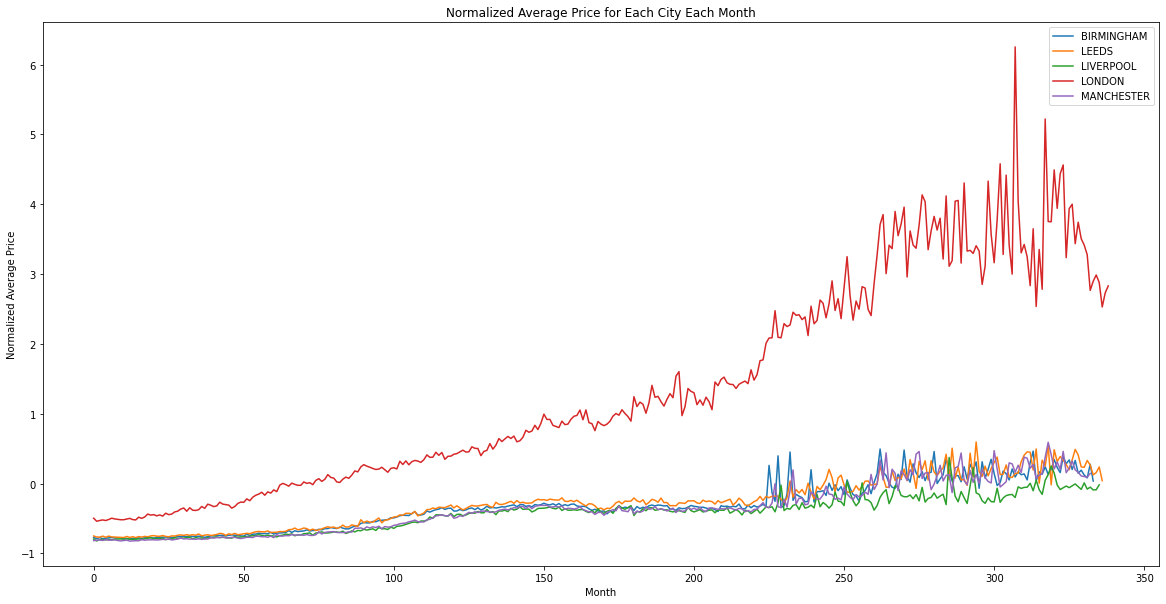

In [0]:
mean_price = no_outliers_df.agg(F.mean(F.col("avg_price")).alias("mean_price")).collect()[0]['mean_price']
std_price = no_outliers_df.agg(F.stddev(F.col("avg_price")).alias("std_price")).collect()[0]['std_price']
no_outliers_df = no_outliers_df.withColumn("normalized_z_score", (F.col("avg_price") - mean_price) / std_price)
no_outliers_df = no_outliers_df.orderBy('Town/City', "Month")

no_outliers_df_pd = no_outliers_df.toPandas()

fig, ax = plt.subplots(figsize=(20, 10))
for city in no_outliers_df_pd['Town/City'].unique():
    city_data = no_outliers_df_pd[no_outliers_df_pd['Town/City'] == city]
    city_data = city_data.reset_index()
    ax.plot(city_data.index, city_data['normalized_z_score'], label=city)

ax.set_xlabel('Month')
ax.set_ylabel('Normalized Average Price')
ax.set_title('Normalized Average Price for Each City Each Month')
ax.legend()

plt.show()

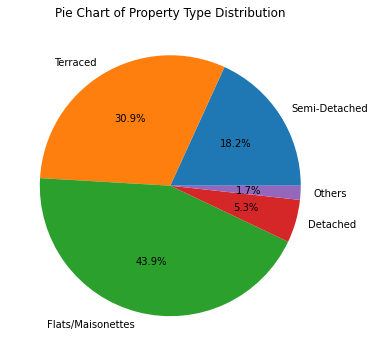

In [0]:
from pyspark.sql.functions import when
updated_df_cleaned = df_cleaned.withColumn(
    'Property_Type', 
    when(F.col('Property_Type') == 'D', 'Detached')
    .when(F.col('Property_Type') == 'S', 'Semi-Detached')
    .when(F.col('Property_Type') == 'T', 'Terraced')
    .when(F.col('Property_Type') == 'F', 'Flats/Maisonettes')
    .when(F.col('Property_Type') == 'O', 'Others')
    .otherwise(F.col('Property_Type'))
)

property_type_counts = updated_df_cleaned.groupBy("Property_Type").count()
property_type_counts_pd = property_type_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.pie(property_type_counts_pd['count'], labels=property_type_counts_pd['Property_Type'], autopct='%1.1f%%')
plt.title('Pie Chart of Property Type Distribution')
plt.show()

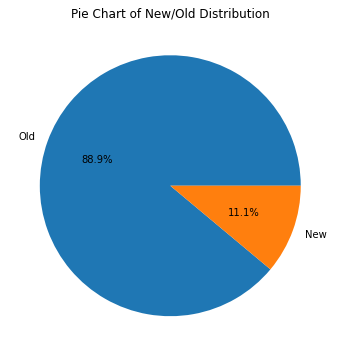

In [0]:
updated_df_cleaned2 = df_cleaned.withColumn(
    'Old/New', 
    when(F.col('Old/New') == 'Y', 'New')
    .when(F.col('Old/New') == 'N', 'Old')
    .otherwise(F.col('Old/New'))
)

oldnew_counts = updated_df_cleaned2.groupBy("Old/New").count()
oldnew_counts_pd = oldnew_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.pie(oldnew_counts_pd['count'], labels=oldnew_counts_pd['Old/New'], autopct='%1.1f%%')
plt.title('Pie Chart of New/Old Distribution')
plt.show()

Town/City avg_price LONDON 483433.3167607957 MANCHESTER 149823.96664173974 BIRMINGHAM 154994.78540699964 LIVERPOOL 141619.65497428263 LEEDS 163869.31260841148

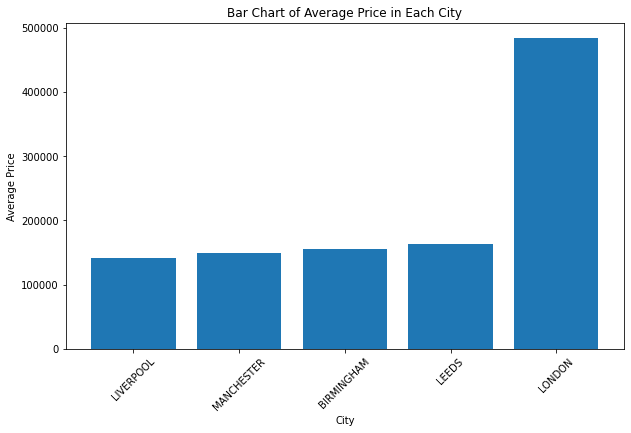

In [0]:
import matplotlib.pyplot as plt
plt_avg_price = df_cleaned.groupBy('Town/City').agg(F.avg("price").alias("avg_price"))
display(plt_avg_price)
plt_avg_price = plt_avg_price.orderBy("avg_price")
plt_avg_price_pd = plt_avg_price.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(plt_avg_price_pd['Town/City'], plt_avg_price_pd['avg_price'])
plt.xlabel('City')
plt.ylabel('Average Price')
plt.title('Bar Chart of Average Price in Each City')
plt.xticks(rotation=45)
plt.show()

In [0]:
results.extend(train_and_evaluate(train_50, test_50,"50%"))

In [0]:
results.extend(train_and_evaluate(train_75, test_75,"75%"))

In [0]:
results.extend(train_and_evaluate(train_100, test_100,"100%"))

In [0]:
results_df = spark.createDataFrame(results)

results_df.show()

In [0]:
results.extend(train_and_evaluate(train_75, test_75,"75%"))
results.extend(train_and_evaluate(train_100, test_100,"100%"))

results_df = spark.createDataFrame(results)

results_df.show()
        "Decision Tree": DecisionTreeRegressor(featuresCol=["Town/City","Location","Month","Property_Type_vec","Old/New_vec","Duration_vec"], labelCol='price'),
        
        "Random Forest": RandomForestRegressor(featuresCol=["Town/City","Location","Month","Property_Type_vec","Old/New_vec","Duration_vec"], labelCol='price')